## Student ID： 40176652
## Name：Zixuan Lu
## STAT 497 Assignment 2

In [8]:
!pip install matplotlib

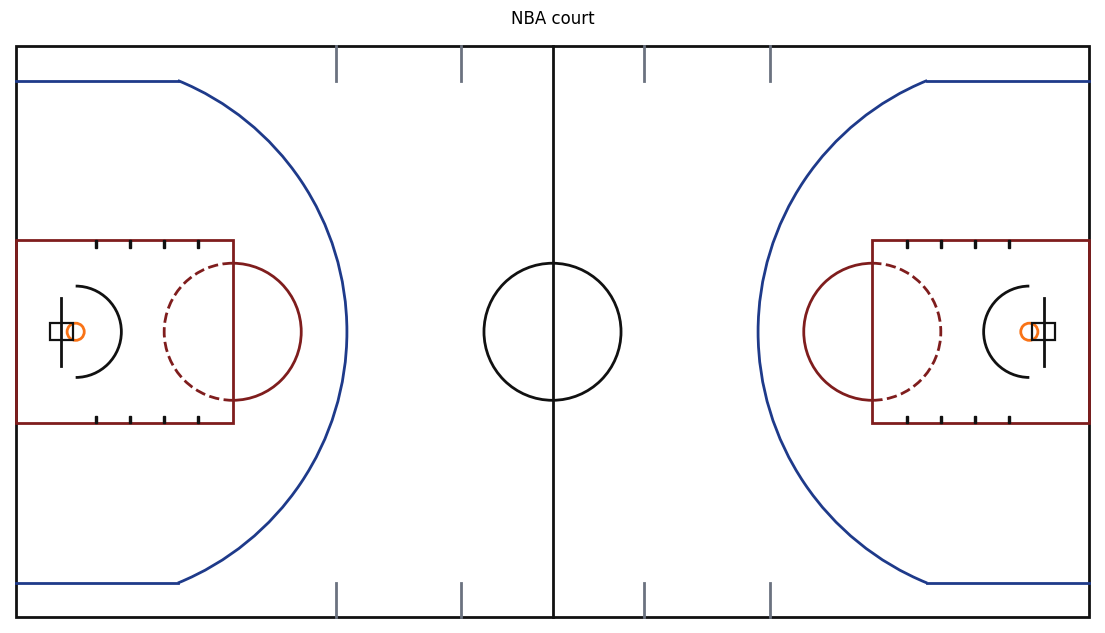

Saved: nba_court_official.png


In [11]:
"""
NBA court (to scale, feet → pixels)
- Basketball (NBA full court). Unit: feet.
- Single world→pixel mapping drives ALL coordinates AND line widths.
- No hardcoded pixels; change `px_per_ft` to resize the whole drawing.
- Dimensions follow commonly published NBA specs.
"""

import math
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc

class FeetToPixels:
    """World→pixel converter used everywhere (coords + line widths)."""
    def __init__(self, px_per_ft: float = 12.0):
        # everything grows/shrinks together
        self.scale = float(px_per_ft)

    def __call__(self, feet: float) -> float:
        return feet * self.scale

    def lw(self, feet: float) -> float:
        """Physical line width (ft) → px, e.g., 2-inch lines = 2/12 ft."""
        return feet * self.scale


def draw_nba_court(px_per_ft: float = 12.0,
                   save_path: str = "nba_court_official.png") -> str:
    to_px = FeetToPixels(px_per_ft)

    # ---- official dimensions (feet) ----
    court_len = 94.0
    court_w   = 50.0

    center_circle_r = 6.0
    key_w           = 16.0
    ft_circle_r     = 6.0                   # free-throw circle radius
    ft_from_backbrd = 15.0                  # FT line distance from backboard plane
    backbrd_to_base = 4.0                   # backboard plane to baseline
    rim_center_off  = 1.25                  # rim center offset from backboard (15 in)
    rim_diameter    = 18.0/12.0             # 18 in → 1.5 ft

    restricted_r    = 4.0                   # no-charge semicircle radius
    corner_3_offset = 3.0                   # straight 3-pt corners sit 3 ft from sideline
    three_r         = 23.75                 # 3-pt arc radius from rim center

    # line widths (feet)
    line_w_ft       = 2.0/12.0              # standard 2-inch game lines
    line_w_minor_ft = line_w_ft * 0.8       # slightly thinner for helper details

    # backboard / shooter’s square
    backboard_half_w = 3.0                  # backboard is 6 ft wide in total
    shooter_sq_w     = 24.0/12.0            # 24" × 18"
    shooter_sq_h     = 18.0/12.0

    # lane-space (slot) marks along the key
    lane_mark_proj   = 8.0/12.0             # mark projects 8" into lane
    lane_mark_thick  = 2.0/12.0             # 2" thick
    lane_mark_xs     = [7.0, 10.0, 13.0, 16.0]  # from baseline toward midcourt

    # sideline reference hashes (timeout/sub boxes)
    timeout_from_base = 28.0
    timeout_len       = 3.0
    sub_box_from_mid  = 8.0
    sub_box_len       = 3.0

    # ---- convert once to px ----
    # convert world dimensions (feet) to pixels once, then reuse everywhere. This avoids any hardcoded pixel numbers and keeps scaling
    # consistent.Example (@ px_per_ft=12): l_px=94*12=1128, w_px=50*12=600 → center at (564, 300).
    l_px, w_px = to_px(court_len), to_px(court_w)
    cx, cy     = l_px / 2.0, w_px / 2.0     # court center (px)

    # hoop centers measured from baselines (both ends)
    hoop_x_from_baseline = backbrd_to_base + rim_center_off
    hoop_l_x  = to_px(hoop_x_from_baseline)
    hoop_r_x  = to_px(court_len - hoop_x_from_baseline)

    # FT circle centers along x (each half)
    ft_line_x_from_base = backbrd_to_base + ft_from_backbrd
    ft_l_x = to_px(ft_line_x_from_base)
    ft_r_x = to_px(court_len - ft_line_x_from_base)

    half_key_w_px = to_px(key_w / 2.0)
    rim_r_px      = to_px(rim_diameter / 2.0)

    # ---- simple color palette ----
    color_lines = "#111111"
    color_paint = "#7f1d1d"
    color_three = "#1e3a8a"
    color_rim   = "#f97316"
    color_hash  = "#6b7280"
    court_bg    = "#f6ecd3"

    lw       = to_px.lw(line_w_ft)
    lw_minor = to_px.lw(line_w_minor_ft)

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.set_aspect("equal")
    ax.set_facecolor(court_bg)

    # ---- boundary, centerline, center circle ----
    # coord system: (0,0) is bottom-left corner; x→right (baseline→baseline), y→up (sideline→sideline)
    ax.add_patch(Rectangle((0, 0), l_px, w_px, fill=False, edgecolor=color_lines, linewidth=lw))
    ax.plot([cx, cx], [0, w_px], color=color_lines, linewidth=lw)
    ax.add_patch(Circle((cx, cy), to_px(center_circle_r), fill=False, edgecolor=color_lines, linewidth=lw))

    # ---- keys (paint) ----
    # lanes drawn as outlines on each half
    ax.add_patch(Rectangle((0, cy - half_key_w_px), ft_l_x, 2 * half_key_w_px,
                           fill=False, edgecolor=color_paint, linewidth=lw))
    ax.add_patch(Rectangle((ft_r_x, cy - half_key_w_px), l_px - ft_r_x, 2 * half_key_w_px,
                           fill=False, edgecolor=color_paint, linewidth=lw))

    # ---- free-throw circles ----
    # segment outside the lane (toward midcourt) is solid; inside the lane is dashed
    ft_r_px = to_px(ft_circle_r)
    # left half
    ax.add_patch(Arc((ft_l_x, cy), 2*ft_r_px, 2*ft_r_px,
                     theta1=-90, theta2=90, edgecolor=color_paint, linewidth=lw))            # outside of key
    ax.add_patch(Arc((ft_l_x, cy), 2*ft_r_px, 2*ft_r_px,
                     theta1=90, theta2=270, edgecolor=color_paint, linewidth=lw, linestyle="--"))  # inside of key
    # right half
    ax.add_patch(Arc((ft_r_x, cy), 2*ft_r_px, 2*ft_r_px,
                     theta1=90, theta2=270, edgecolor=color_paint, linewidth=lw))            # outside of key
    ax.add_patch(Arc((ft_r_x, cy), 2*ft_r_px, 2*ft_r_px,
                     theta1=-90, theta2=90, edgecolor=color_paint, linewidth=lw, linestyle="--"))  # inside of key

    # ---- restricted area semicircles ----
    rest_r_px = to_px(restricted_r)
    ax.add_patch(Arc((hoop_l_x, cy), 2*rest_r_px, 2*rest_r_px,
                     theta1=-90, theta2=90, edgecolor=color_lines, linewidth=lw))
    ax.add_patch(Arc((hoop_r_x, cy), 2*rest_r_px, 2*rest_r_px,
                     theta1=90, theta2=270, edgecolor=color_lines, linewidth=lw))

    # ---- three-point geometry (corner lines + arc) ----
    # corners: straight segments 3 ft from sidelines
    y_low_px  = to_px(corner_3_offset)
    y_high_px = to_px(court_w - corner_3_offset)

    # let R = three_r, hoop at (0, 0) in its local frame.
    # the corner line is at vertical offset d_y = (court_w/2 - 3).
    # angle where the arc meets the straight line: sin(theta0) = d_y / R  → theta0 = asin(d_y/R).
    # horizontal reach at that angle: x_off = sqrt(R^2 - d_y^2).
    d_y_ft   = (court_w / 2.0) - corner_3_offset
    theta0   = math.degrees(math.asin(d_y_ft / three_r))    # meeting angle in degrees
    x_off_px = to_px(math.sqrt(three_r**2 - d_y_ft**2))     # horizontal join distance (px)
    three_r_px = to_px(three_r)

    # left end
    left_join_x = hoop_l_x + x_off_px
    ax.plot([0, left_join_x], [y_low_px,  y_low_px],  color=color_three, linewidth=lw)
    ax.plot([0, left_join_x], [y_high_px, y_high_px], color=color_three, linewidth=lw)
    ax.add_patch(Arc((hoop_l_x, cy), 2*three_r_px, 2*three_r_px,
                     theta1=-theta0, theta2=theta0, edgecolor=color_three, linewidth=lw))
    # right end (mirror of left)
    right_join_x = hoop_r_x - x_off_px
    ax.plot([right_join_x, l_px], [y_low_px,  y_low_px],  color=color_three, linewidth=lw)
    ax.plot([right_join_x, l_px], [y_high_px, y_high_px], color=color_three, linewidth=lw)
    ax.add_patch(Arc((hoop_r_x, cy), 2*three_r_px, 2*three_r_px,
                     theta1=180 - theta0, theta2=180 + theta0, edgecolor=color_three, linewidth=lw))

    # ---- backboards, rims & shooter’s square ----
    # backboard planes are 4 ft from each baseline
    bb_half_px = to_px(backboard_half_w)
    bb_l_x = to_px(backbrd_to_base)
    bb_r_x = to_px(court_len - backbrd_to_base)
    ax.plot([bb_l_x, bb_l_x], [cy - bb_half_px, cy + bb_half_px], color=color_lines, linewidth=lw)
    ax.plot([bb_r_x, bb_r_x], [cy - bb_half_px, cy + bb_half_px], color=color_lines, linewidth=lw)

    # rim circles (visual only)
    ax.add_patch(Circle((hoop_l_x, cy), rim_r_px, fill=False, edgecolor=color_rim, linewidth=lw))
    ax.add_patch(Circle((hoop_r_x, cy), rim_r_px, fill=False, edgecolor=color_rim, linewidth=lw))

    # shooter’s square on backboard
    ax.add_patch(Rectangle((bb_l_x - to_px(shooter_sq_w/2), cy - to_px(shooter_sq_h/2)),
                           to_px(shooter_sq_w), to_px(shooter_sq_h),
                           fill=False, edgecolor=color_lines, linewidth=lw_minor))
    ax.add_patch(Rectangle((bb_r_x - to_px(shooter_sq_w/2), cy - to_px(shooter_sq_h/2)),
                           to_px(shooter_sq_w), to_px(shooter_sq_h),
                           fill=False, edgecolor=color_lines, linewidth=lw_minor))

    # ---- lane-space (slot) marks, mirrored on both halves ----
    mark_len_px = to_px(lane_mark_proj)
    mark_thk_px = to_px(lane_mark_thick)
    y_paint_top = cy + half_key_w_px
    y_paint_bot = cy - half_key_w_px

    for xf in lane_mark_xs:
        x_l = to_px(xf)
        x_r = to_px(court_len - xf)
        # bottom edge of lane
        ax.add_patch(Rectangle((x_l - mark_thk_px/2, y_paint_bot), mark_thk_px, mark_len_px,
                               facecolor=color_lines, edgecolor=color_lines))
        ax.add_patch(Rectangle((x_r - mark_thk_px/2, y_paint_bot), mark_thk_px, mark_len_px,
                               facecolor=color_lines, edgecolor=color_lines))
        # top edge (mirror)
        ax.add_patch(Rectangle((x_l - mark_thk_px/2, y_paint_top - mark_len_px), mark_thk_px, mark_len_px,
                               facecolor=color_lines, edgecolor=color_lines))
        ax.add_patch(Rectangle((x_r - mark_thk_px/2, y_paint_top - mark_len_px), mark_thk_px, mark_len_px,
                               facecolor=color_lines, edgecolor=color_lines))

    # ---- sideline hashes (timeout / substitution reference) ----
    for x in [to_px(timeout_from_base), to_px(court_len - timeout_from_base)]:
        ax.plot([x, x], [0, to_px(timeout_len)], color=color_hash, linewidth=lw)
        ax.plot([x, x], [w_px - to_px(timeout_len), w_px], color=color_hash, linewidth=lw)

    for x in [to_px(court_len/2 - sub_box_from_mid), to_px(court_len/2 + sub_box_from_mid)]:
        ax.plot([x, x], [0, to_px(sub_box_len)], color=color_hash, linewidth=lw)
        ax.plot([x, x], [w_px - to_px(sub_box_len), w_px], color=color_hash, linewidth=lw)

    # export
    # small padding avoids clipping when bbox_inches="tight"
    pad = to_px(1.0)
    ax.set_xlim(-to_px(0.5), l_px + to_px(0.5))
    ax.set_ylim(-to_px(0.5), w_px + to_px(0.5))
    ax.axis("off")

    plt.title("NBA court", pad=pad)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    return save_path


if __name__ == "__main__":
    out = draw_nba_court(px_per_ft=12.0, save_path="nba_court_official.png")
    print(f"Saved: {out}")
